In [1]:
from __future__ import annotations
from itertools import product
from dataclasses import dataclass
from collections import defaultdict
import math
import statistics
import random
from typing import Optional, Iterator, Iterable

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Game Constants

In [2]:
FIGURES = ["9", "10", "J", "Q", "K", "A"]  # 5 playable + 9 acts as a jocker
AMOUNTS = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # On one hand we have 5 cards

DECK = [
    "A", "A", "A", "A",
    "K", "K", "K", "K",
    "Q", "Q", "Q", "Q",
    "J", "J", "J", "J",
    "10", "10", "10", "10",
    "9", "9", "9", "9"
]


## Utility classes and functions

In [3]:
@dataclass(frozen=True)
class Bet:
    figure: str
    amount: int

In [4]:
def hand_to_counts(hand: list[str]) -> list[int]:
    return [hand.count(figure) for figure in FIGURES]


def argmax(iterable: Iterable[float]):
    return max(enumerate(iterable), key=lambda x: x[1])[0]


def shuffle_hands() -> tuple[list[str], list[str]]:
    two_hands = random.sample(DECK, 10)
    return two_hands[:5], two_hands[5:]


def allowed_bets(prev_bet: Bet) -> Iterator[Bet]:
    if prev_bet.amount != 0:
        for figure in FIGURES[FIGURES.index(prev_bet.figure) + 1:]: 
            yield Bet(figure, prev_bet.amount)

    for amount in AMOUNTS[prev_bet.amount + 1:]:  # Start from the 1 bigger amount
        for figure in FIGURES[1:]:  # Omit 9
            yield Bet(figure, amount)

In [5]:
list(allowed_bets(Bet("A", 4)))

[Bet(figure='10', amount=5),
 Bet(figure='J', amount=5),
 Bet(figure='Q', amount=5),
 Bet(figure='K', amount=5),
 Bet(figure='A', amount=5),
 Bet(figure='10', amount=6),
 Bet(figure='J', amount=6),
 Bet(figure='Q', amount=6),
 Bet(figure='K', amount=6),
 Bet(figure='A', amount=6),
 Bet(figure='10', amount=7),
 Bet(figure='J', amount=7),
 Bet(figure='Q', amount=7),
 Bet(figure='K', amount=7),
 Bet(figure='A', amount=7),
 Bet(figure='10', amount=8),
 Bet(figure='J', amount=8),
 Bet(figure='Q', amount=8),
 Bet(figure='K', amount=8),
 Bet(figure='A', amount=8)]

## Probability based player (StatPlayer)

In [6]:
CONFIDECE_THRESHOLD = 0.5

In [7]:
class StatPlayer:
    hand: list[str]

    def __init__(self, hand: list[str]):
        self.hand = hand

        self.counts = hand_to_counts(hand)
        self.counts_left = [4 - count for count in self.counts]

    def eval_bet_probability(self, bet: Bet) -> float:
        assert bet.figure in FIGURES
        assert bet.figure != "9"
        assert 0 <= bet.amount <= 10

        # If we have enough cards of the figure on hand
        figure_idx = FIGURES.index(bet.figure)
        if bet.amount <= self.counts[figure_idx]:
            return 1.0

        # Probability of the other player having the rest of the cards needed
        needed_amount = bet.amount - self.counts[figure_idx]
        wanted = (
            self.counts_left[figure_idx]
            + self.counts_left[0] # ID for "9"
        )
        all_sum = sum(self.counts_left)

        s = 0
        for i in range(needed_amount, 6):
            s += math.comb(wanted, i) * math.comb(all_sum - wanted, 5 - i)
        return s / math.comb(all_sum, 5)

    def next_bet(self, prev_bet: Bet) -> Optional[Bet]:
        """Returns None if the player doesn't want to bet. Otherwise, returns the figure and the amount."""
        prob = self.eval_bet_probability(prev_bet)
        if prob < CONFIDECE_THRESHOLD:
            return None

        possible_bets = list(allowed_bets(prev_bet))
        probs = [
            self.eval_bet_probability(bet)
            for bet in possible_bets
        ]
        argmax_prob = argmax(probs)
        best_bet = possible_bets[argmax_prob]
        return best_bet

In [8]:
test_player = StatPlayer(["A", "A", "A", "K", "K"])
print(test_player.eval_bet_probability(Bet("A", 3)))
print(test_player.eval_bet_probability(Bet("A", 4)))
print(test_player.eval_bet_probability(Bet("A", 5)))
print(test_player.next_bet(Bet("A", 4)))

1.0
0.8278293773649811
0.3974028207774338
Bet(figure='A', amount=5)


## Environment setup

In [9]:
class Environment:
    def __init__(self):
        h1, h2 = shuffle_hands()
        self.player_hand = h1
        self.hidden_hand = h2
        self.cards = h1 + h2
        self.counts = hand_to_counts(self.cards)

        self.stat_player = StatPlayer(self.hidden_hand)
        self.last_bet = None

    def init(self) -> tuple[list[str], Bet]:
        """Returns the player hand and the first bet of the stat player"""
        dummy_bet = Bet("A", 0)
        real_bet = self.stat_player.next_bet(dummy_bet)
        self.last_bet = real_bet
        return self.player_hand, real_bet
    
    def check(self, bet: Bet) -> bool:
        figure_count = self.cards.count(bet.figure)
        nines_count = self.counts[0] # 9 index
        if figure_count + nines_count >= bet.amount:
            return True
        return False

    def step(self, bet: Optional[Bet]) -> tuple[Optional[Bet], float, bool]:
        """Returns oponent next bet if any, reward, and bool flag terminated"""
        assert self.last_bet is not None, "Call init before step"
        
        if bet is None:
            if self.check(self.last_bet):
                # Player looses because the hands are checked and env bet is true
                return None, -1, True
            else:
                # Player wins because the hands are checked and env bet was false
                return None, 1, True

        env_bet = self.stat_player.next_bet(bet)
        if env_bet is None:
            if self.check(bet):
                return None, 1, True
            else:
                return None, -1, True

        return env_bet, 0, False

In [10]:
test_env = Environment()
hand, env_bet = test_env.init()
print(test_env.cards)
print(test_env.step(Bet("A", 4)))

['A', '10', 'K', 'A', '9', '9', 'J', 'Q', '10', 'A']
(None, 1, True)


## Q Table wrapper class

In [11]:
class QTable:
    q_table: np.ndarray

    def __init__(self, impossible_value = -np.inf, start_value = 0):
        self.q_table = QTable.init_q_table(impossible_value, start_value)

    @property
    def shape(self):
        return self.q_table.shape
        
    @staticmethod
    def init_q_table(impossible_value: float = -np.inf, start_value: float = 0.0):
        # 5 figure counts number from 0 to 4 (the last one is left for the jocker), oponent bet, my bet
        q_table = (
            np.ones((5, 5, 5, 5, 5, 6, 9, 6, 9), dtype=np.float64) * impossible_value
        )
        
        counts_ranges = [list(range(0, 5)) for _ in range(5)]
        for hand_counts in product(*counts_ranges):
            if 1 <= sum(hand_counts) <= 5:
                h1, h2, h3, h4, h5 = hand_counts
                for figure, amount in product(FIGURES[1:], AMOUNTS[1:]):
                    figure_id = FIGURES.index(figure)
                    q_table[
                        h1, h2, h3, h4, h5, figure_id, amount, 0, 0
                    ] = start_value  # This indicates calling the bluff zero of 9

                    
                    bet = Bet(figure, amount)
                    for my_bet in allowed_bets(bet):
                        my_fig_id = FIGURES.index(my_bet.figure)
                        my_amount = my_bet.amount
                        q_table[
                            h1, h2, h3, h4, h5, figure_id, amount, my_fig_id, my_amount
                        ] = start_value

        return q_table

    def __getitem__(self, key: tuple):
        assert isinstance(key, tuple)
        if len(key) == 2:
            # This is state
            hand, env_bet = key
            c1, c2, c3, c4, c5 = hand_to_counts(hand)[1:] # Figure counts without 9
            fi = FIGURES.index(env_bet.figure)
            a = env_bet.amount
            return self.q_table[c1, c2, c3, c4, c5, fi, a, :, :]
        if len(key) == 3:
            # This is state, action pair
            hand, env_bet, my_bet = key
            action_values = self[hand, env_bet]
            fi = FIGURES.index(my_bet.figure)
            a = my_bet.amount
            return action_values[fi, a]

    def __setitem__(self, key: tuple, value: float):
        assert isinstance(key, tuple)
        assert len(key) == 3
        hand, env_bet, my_bet = key
        c1, c2, c3, c4, c5 = hand_to_counts(hand)[1:] # Figure counts without 9
        fi = FIGURES.index(env_bet.figure)
        a = env_bet.amount
        if my_bet is None:
            my_fi = 0
            my_a = 0
        else:
            my_fi = FIGURES.index(my_bet.figure)
            my_a = my_bet.amount
        self.q_table[c1, c2, c3, c4, c5, fi, a, my_fi, my_a] = value


In [12]:
test_q_table = QTable()
hand = ["A", "A", "A", "K", "K"]
env_bet = Bet("A", 3)
bet = Bet("A", 4)
print(test_q_table[hand, env_bet])
print(test_q_table[hand, env_bet, bet])

[[  0. -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf   0.   0.   0.   0.   0.]
 [-inf -inf -inf -inf   0.   0.   0.   0.   0.]
 [-inf -inf -inf -inf   0.   0.   0.   0.   0.]
 [-inf -inf -inf -inf   0.   0.   0.   0.   0.]
 [-inf -inf -inf -inf   0.   0.   0.   0.   0.]]
0.0


## RL Time

### Random 
Select from the range of possible actions one action at random

In [13]:
EPISODES = 10_000

In [14]:
episode_rewards = []
q_table = QTable()
for episode in tqdm(range(EPISODES)):
    env = Environment()
    hand, env_bet = env.init()
    terminated = False
    reward = 0
    while not terminated:
        bet = random.choice(list(allowed_bets(env_bet)) + [None])
        env_bet, reward, terminated = env.step(bet)
        
    episode_rewards.append(reward)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6145.48it/s]


In [15]:
print(f"Win rate: {episode_rewards.count(1) * 100 / EPISODES}%")

Win rate: 14.66%


### Exploring Starts MC Control

Screen taken from: Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

<img src="MC-ES.png" alt="Exploring Starts algorithm" width="600"/>

In [16]:
EPISODES = 1_000_000

In [17]:
# There is a problem that the agnet only explores only the first move
# The search cannot happen after that.
# Even thought this works as the game length is not that long

In [18]:
q_table = QTable()
returns = defaultdict(list)
global_rewards = []
for episode in tqdm(range(EPISODES)):
    # Init episode
    states, actions, rewards = [], [], []
    env = Environment()
    hand, env_bet = env.init()
    terminated = False
    reward = 0
    # Play episode
    # Bet is our action
    first = True
    # Random start
    while not terminated:
        if first:
            bets = list(allowed_bets(env_bet)) + [None]
            bet = random.choice(bets)
            first = False
        else:
            action_table = q_table[hand, env_bet]
            idx = np.unravel_index(np.argmax(action_table, axis=None), action_table.shape)
            if idx[1] == 0:
                bet = None
            else:
                bet = Bet(FIGURES[idx[0]], idx[1])
                
        states.append((hand, env_bet))
        actions.append(bet)
        
        env_bet, reward, terminated = env.step(bet)
        
        rewards.append(reward)
        
    global_rewards.append(reward)
        
    # After Q values after episode ends
    g = 0
    for t in range(len(rewards) - 1, -1, -1):
        g += rewards[t]
        state, action = states[t], actions[t]
        if (not state in states[:t]) and (not action in actions[:t]):
            hand, env_bet = state
            count = tuple(hand_to_counts(hand))
            idx = (count, env_bet, action)
            returns[idx].append(g)
            q_table[hand, env_bet, bet] = statistics.mean(returns[idx])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [03:51<00:00, 4323.01it/s]


In [19]:
print(f"Win rate: {global_rewards.count(1) * 100 / EPISODES}%")

Win rate: 28.173%


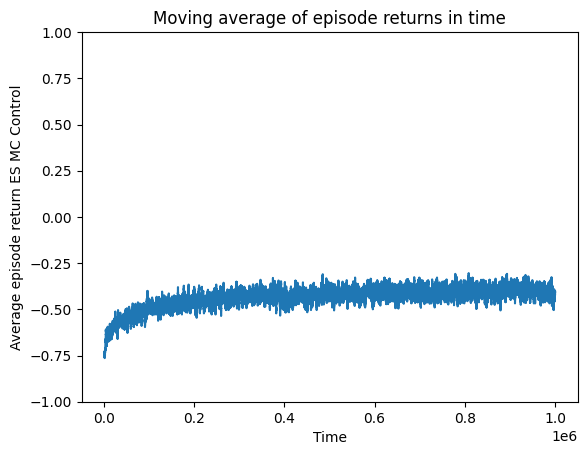

In [20]:
moving_average = pd.Series(global_rewards).rolling(window = 1_000).mean().plot()
plt.title("Moving average of episode returns in time")
plt.xlabel("Time")
plt.ylabel("Average episode return ES MC Control")
ax = plt.gca()
ax.set_ylim([-1, 1])
plt.show()

#### Evaluation

In [21]:
global_rewards = []
counts = []
for episode in tqdm(range(100_000)):
    # Init episode
    states, actions, rewards = [], [], []
    env = Environment()
    hand, env_bet = env.init()
    terminated = False
    reward = 0
    # Play episode
    # Bet is our action
    counter = 0
    while not terminated:
        action_table = q_table[hand, env_bet]
        idx = np.unravel_index(np.argmax(action_table, axis=None), action_table.shape)
        if idx[1] == 0:
            bet = None
        else:
            bet = Bet(FIGURES[idx[0]], idx[1])
                
        states.append((hand, env_bet))
        actions.append(bet)
        
        env_bet, reward, terminated = env.step(bet)
        counter += 1
        
        rewards.append(reward)
    counts.append(counter)
        
    global_rewards.append(reward)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:17<00:00, 5559.71it/s]


In [22]:
print(f"Win rate: {global_rewards.count(1) * 100 / 100_000}%")

Win rate: 75.106%


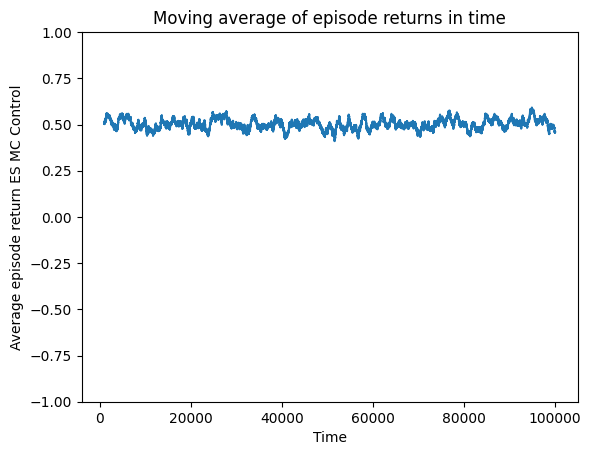

In [23]:
moving_average = pd.Series(global_rewards).rolling(window = 1_000).mean().plot()
plt.title("Moving average of episode returns in time")
plt.xlabel("Time")
plt.ylabel("Average episode return ES MC Control")
ax = plt.gca()
ax.set_ylim([-1, 1])
plt.show()

<Axes: title={'center': 'Histogram of returns by game time'}, xlabel='Game time'>

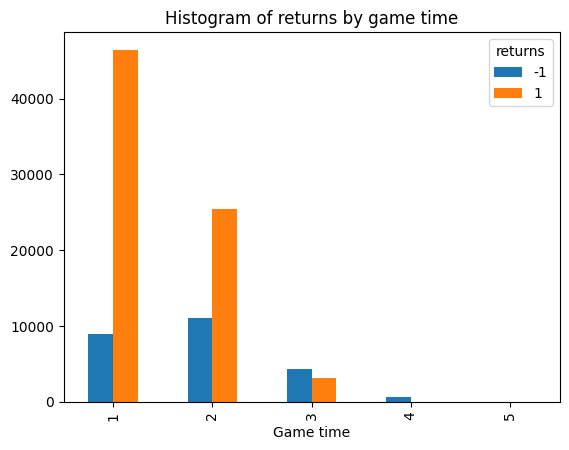

In [24]:
pd.DataFrame({
    "returns": pd.Series(global_rewards),
    "game_time": pd.Series(counts)
}).groupby("game_time")["returns"].value_counts().unstack().plot.bar(
    xlabel = "Game time",
    title = "Histogram of returns by game time"
)

### On-policy First Visit MC Control

Screen taken from: Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

<img src="MC-FV.png" alt="First visit algorithm" width="600"/>

In [25]:
EPISODES = 1_000_000
EPSILON = 0.1

In [26]:
q_table = QTable()
returns = defaultdict(list)
global_rewards = []
for episode in tqdm(range(EPISODES)):
    # Init episode
    states, actions, rewards = [], [], []
    env = Environment()
    hand, env_bet = env.init()
    terminated = False
    reward = 0
    # Play episode
    # Bet is our action
    while not terminated:
        if random.random() < EPSILON:
            bets = list(allowed_bets(env_bet)) + [None]
            bet = random.choice(bets)
        else:
            action_table = q_table[hand, env_bet]
            idx = np.unravel_index(np.argmax(action_table, axis=None), action_table.shape)
            if idx[1] == 0:
                bet = None
            else:
                bet = Bet(FIGURES[idx[0]], idx[1])
                
        states.append((hand, env_bet))
        actions.append(bet)
        
        env_bet, reward, terminated = env.step(bet)
        
        rewards.append(reward)
        
    global_rewards.append(reward)
        
    # After Q values after episode ends
    g = 0
    for t in range(len(rewards) - 1, -1, -1):
        g += rewards[t]
        state, action = states[t], actions[t]
        if (not state in states[:t]) and (not action in actions[:t]):
            hand, env_bet = state
            count = tuple(hand_to_counts(hand))
            idx = (count, env_bet, action)
            returns[idx].append(g)
            q_table[hand, env_bet, bet] = statistics.mean(returns[idx])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [07:52<00:00, 2118.56it/s]


In [27]:
print(f"Win rate: {global_rewards.count(1) * 100 / EPISODES}%")

Win rate: 68.8265%


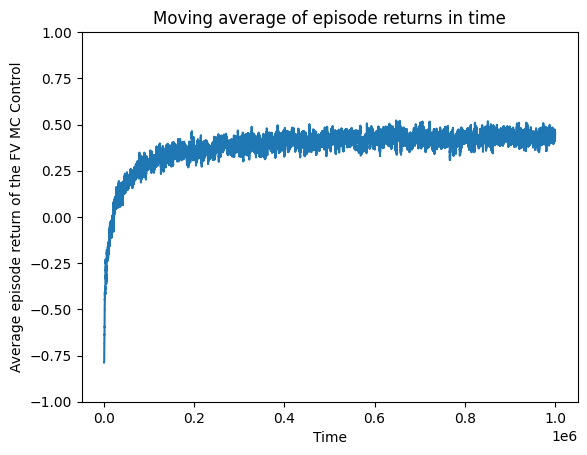

In [28]:
moving_average = pd.Series(global_rewards).rolling(window = 1_000).mean().plot()
plt.title("Moving average of episode returns in time")
plt.xlabel("Time")
plt.ylabel("Average episode return of the FV MC Control")
ax = plt.gca()
ax.set_ylim([-1, 1])
plt.show()

#### Sample games

In [29]:
for episode in range(20):
    # Init episode
    states, actions, rewards = [], [], []
    env = Environment()
    hand, env_bet = env.init()
    terminated = False
    reward = 0
    # Play episode
    # Bet is our action
    while not terminated:
        action_table = q_table[hand, env_bet]
        idx = np.unravel_index(np.argmax(action_table, axis=None), action_table.shape)
        if idx[1] == 0:
            bet = None
        else:
            bet = Bet(FIGURES[idx[0]], idx[1])

        states.append((hand, env_bet))
        actions.append(bet)
        
        env_bet, reward, terminated = env.step(bet)
        
        rewards.append(reward)

    print(f"### EPISODE:{episode}, Result: {reward}")
    print(f"My hand: {str(hand)}")
    print(f"Env hand: {str(env.hidden_hand)}")
    for s, a in zip(states, actions):
        print(f"Env: {str(s[1])} -> Agnet: {str(a)}")
    print()


### EPISODE:0, Result: -1
My hand: ['Q', '10', 'J', 'Q', 'A']
Env hand: ['Q', 'K', '10', 'A', '10']
Env: Bet(figure='10', amount=1) -> Agnet: Bet(figure='10', amount=2)
Env: Bet(figure='Q', amount=2) -> Agnet: Bet(figure='Q', amount=4)

### EPISODE:1, Result: 1
My hand: ['9', 'A', '10', 'J', 'K']
Env hand: ['J', '10', '9', '9', 'A']
Env: Bet(figure='10', amount=1) -> Agnet: Bet(figure='10', amount=4)

### EPISODE:2, Result: 1
My hand: ['9', '9', 'A', 'Q', 'A']
Env hand: ['J', 'K', 'K', 'Q', '9']
Env: Bet(figure='J', amount=1) -> Agnet: Bet(figure='A', amount=4)

### EPISODE:3, Result: 1
My hand: ['J', '10', 'K', 'A', 'K']
Env hand: ['10', '9', 'A', 'J', '10']
Env: Bet(figure='10', amount=1) -> Agnet: Bet(figure='K', amount=3)

### EPISODE:4, Result: -1
My hand: ['A', '10', 'J', '9', '10']
Env hand: ['A', 'Q', 'K', 'Q', '10']
Env: Bet(figure='10', amount=1) -> Agnet: Bet(figure='10', amount=5)

### EPISODE:5, Result: 1
My hand: ['K', '9', 'A', 'A', '9']
Env hand: ['J', '10', 'A', 'J', '

#### Evaluation

In [30]:
global_rewards = []
counts = []
for episode in tqdm(range(100_000)):
    # Init episode
    states, actions, rewards = [], [], []
    env = Environment()
    hand, env_bet = env.init()
    terminated = False
    reward = 0
    # Play episode
    # Bet is our action
    counter = 0
    while not terminated:
        action_table = q_table[hand, env_bet]
        idx = np.unravel_index(np.argmax(action_table, axis=None), action_table.shape)
        if idx[1] == 0:
            bet = None
        else:
            bet = Bet(FIGURES[idx[0]], idx[1])
                
        states.append((hand, env_bet))
        actions.append(bet)
        
        env_bet, reward, terminated = env.step(bet)
        counter += 1
        
        rewards.append(reward)
    counts.append(counter)
        
    global_rewards.append(reward)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:17<00:00, 5753.84it/s]


In [31]:
print(f"Win rate: {global_rewards.count(1) * 100 / 100_000}%")

Win rate: 76.684%


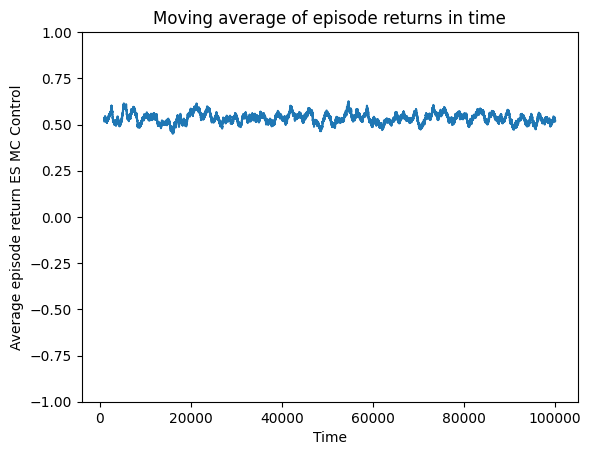

In [32]:
moving_average = pd.Series(global_rewards).rolling(window = 1_000).mean().plot()
plt.title("Moving average of episode returns in time")
plt.xlabel("Time")
plt.ylabel("Average episode return ES MC Control")
ax = plt.gca()
ax.set_ylim([-1, 1])
plt.show()

<Axes: xlabel='game_time'>

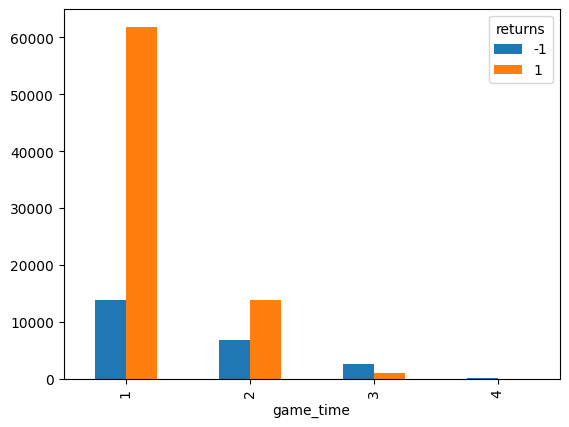

In [33]:
pd.DataFrame({
    "returns": pd.Series(global_rewards),
    "game_time": pd.Series(counts)
}).groupby("game_time")["returns"].value_counts().unstack().plot.bar()